## Import some helpful libraries

In [12]:
print("    Version control\n------------------------")
import os, fnmatch, random, datetime, math, sys
from pathlib import Path
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras as K;               print("Keras\t\t {}".format(K.__version__))
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import *
from keras.callbacks import TensorBoard, EarlyStopping

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.3.1
Keras		 2.3.1


## Loading Dataset

In [14]:
## Load train data
sample_train_subset = np.loadtxt("sample_train_1.csv", dtype=str, delimiter=",")
train_data = np.load('train_1.npy').reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## Load validation data
sample_val_subset = np.loadtxt("sample_valid_1.csv", dtype=str, delimiter=",")
valid_data = np.load('valid_1.npy').reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

## Load last weights
last_weights = str(Path(os.path.join(os.getcwd(), "Weights")) / "w_1.hdf5")
print(last_weights)

train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)
/Users/shossein/GitHub/DTI_Clustering/Weights/w_1.hdf5


In [30]:
print("There are", len(sample_train_subset), " subset of train samples are:\n")
print(*sample_train_subset, sep='\t')
print("\n--------------------------------------------------------------------------------\n")
print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
print(*sample_val_subset, sep='\t')

There are 100  subset of train samples are:

Pat_100_1-post.nii.gz	Pat_101_1-post.nii.gz	Pat_102_1-post.nii.gz	Pat_103_1-post.nii.gz	Pat_107_1-post.nii.gz	Pat_108_1-post.nii.gz	Pat_109_1-post.nii.gz	Pat_110_1-post.nii.gz	Pat_114_1-post.nii.gz	Pat_115_1-post.nii.gz	Pat_116_1-post.nii.gz	Pat_117_1-post.nii.gz	Pat_118_1-post.nii.gz	Pat_11_1-post.nii.gz	Pat_121_1-post.nii.gz	Pat_122_1-post.nii.gz	Pat_123_1-post.nii.gz	Pat_126_1-post.nii.gz	Pat_127_1-post.nii.gz	Pat_129_1-post.nii.gz	Pat_12_1-post.nii.gz	Pat_130_1-post.nii.gz	Pat_131_1-post.nii.gz	Pat_132_1-post.nii.gz	Pat_135_1-post.nii.gz	Pat_137_1-post.nii.gz	Pat_138_1-post.nii.gz	Pat_139_1-post.nii.gz	Pat_13_1-post.nii.gz	Pat_140_1-post.nii.gz	Pat_141_1-post.nii.gz	Pat_142_1-post.nii.gz	Pat_143_1-post.nii.gz	Pat_144_1-post.nii.gz	Pat_145_1-post.nii.gz	Pat_15_1-post.nii.gz	Pat_16_1-post.nii.gz	Pat_17_1-post.nii.gz	Pat_18_1-post.nii.gz	Pat_19_1-post.nii.gz	Pat_21_1-post.nii.gz	Pat_22_1-post.nii.gz	Pat_23_1-post.nii.gz	Pat_24_1-post.nii.gz

In [22]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray
        
# for m in range(train_data.shape[0]):
# for m in range(1):
#     slice_0 = train_data[m, 91, :, :, 0]
#     slice_1 = train_data[m, :, 109, :, 0]
#     slice_2 = train_data[m, :, :, 91, 0]
#     show_slices([slice_0, slice_1, slice_2])
#     plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

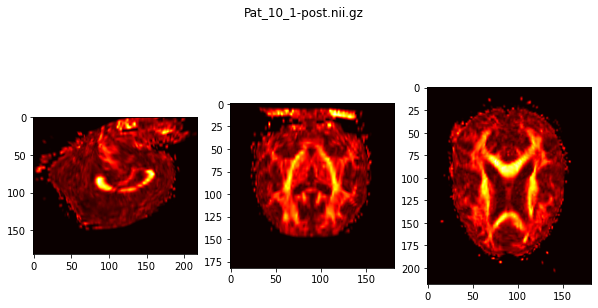

In [23]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

# for m in range(valid_data.shape[0]):
for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle(sample_val_subset[m], x=0.5, y=1)

## Model Design

In [16]:
## Define parameters:
IMAGE_HEIGHT = train_data.shape[1]
IMAGE_WIDTH = train_data.shape[2]
IMAGE_DEPTH = train_data.shape[3]

batch_size = 1                                                                                                       # Change

data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("input-layer shape:", input_shape)

## Encoder
input_img = Input(shape=(182, 218, 182, 1))
x = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)          # Change
x = BatchNormalization()(x)

x = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x)                  # Change
x = BatchNormalization()(x)

x = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x)                  # Change
x = BatchNormalization()(x)

## Decoder
x = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu', name='DeConv1')(x)
x = BatchNormalization()(x)
x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters=32, kernel_size=3, padding='same', activation='relu', name='DeConv2')(x)
x = BatchNormalization()(x)
x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters=64, kernel_size=(2,4,2), padding='valid', activation='relu', name='DeConv3')(x)
x = BatchNormalization()(x)
x = UpSampling3D(size=(2, 2, 2))(x)

decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x)

model_CAE = Model(inputs=input_img, outputs=decoded)
## optimizer=rmsprop, sgd    loss=binary_crossentropy, SparseCategoricalCrossentropy(from_logits=False)
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()

input-layer shape: [1, 182, 218, 182, 1]
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 182, 218, 182, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 91, 109, 91, 64)   1792      
_________________________________________________________________
batch_normalization_24 (Batc (None, 91, 109, 91, 64)   256       
_________________________________________________________________
Conv2 (Conv3D)               (None, 46, 55, 46, 32)    55328     
_________________________________________________________________
batch_normalization_25 (Batc (None, 46, 55, 46, 32)    128       
_________________________________________________________________
Conv3 (Conv3D)               (None, 23, 28, 23, 16)    13840     
_________________________________________________________________
batch_normali

## Model Training

In [17]:
## Tensorboard
%load_ext tensorboard
# %reload_ext tensorboard
logdir = os.path.join("Logs", datetime.datetime.now().strftime("%Y_%m_%d____%H_%M_%S"))
tb_callback = TensorBoard(logdir, histogram_freq=1)

In [41]:
## Start time:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
print("\nStart Time =", start_time, "\n")

## Model Fit
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
# model_CAE.load_weights(last_weights, by_name = True)


Start Time = 04:01:56 



In [42]:
model_CAE.fit(train_data, train_data, epochs=1, batch_size=batch_size, shuffle=True, validation_data=(valid_data, valid_data), callbacks=[tb_callback], verbose=1)

  1/100 [..............................] - ETA: 0s - loss: 0.2501 - accuracy: 0.3558WARNING:tensorflow:From /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
100/100 [==============================] - 538s 5s/step - loss: 0.1439 - accuracy: 0.6833 - val_loss: 0.0949 - val_accuracy: 0.7067


In [ ]:








model_CAE.save_weights("CAE_weights.hdf5")
str(Path(os.path.join(os.getcwd(), "Weights")) / "w_2.hdf5")

# End time:
from datetime import datetime
end_time = datetime.now().strftime("%H:%M:%S")
print("\nEnd Time =", end_time)


Start Time = 02:58:56 

  1/100 [..............................] - ETA: 1s - loss: 0.2687 - accuracy: 0.1951WARNING:tensorflow:From /Users/shossein/anaconda3/envs/m36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
 48/100 [=============>................] - ETA: 1:11:31 - loss: 0.0515 - accuracy: 0.6913

In [ ]:
tensorboard --logdir=CAE_logs       # http://localhost:6006/

In [24]:
model_CAE.load_weights("P_weights.hdf5")     # loading weights
test_data = valid_data[0,:].reshape(1, 182, 218, 182, 1)
reconstructed = model_CAE.predict(test_data)

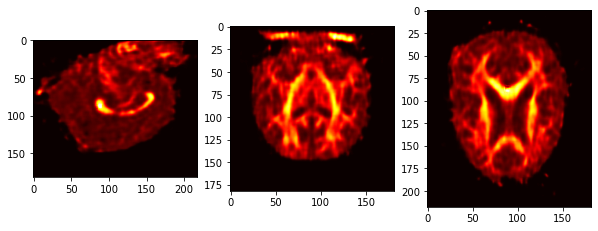

In [25]:
for m in range(1):
    slice_0 = reconstructed[m, 91, :, :, 0]
    slice_1 = reconstructed[m, :, 109, :, 0]
    slice_2 = reconstructed[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])

In [10]:
print('\ntrain_data[0,100,100:105,100]\n\n {}'.format(train_data[0,100,100:105,100]),'\n')
print('\nReconstructed_data[0,100,100:105,100]\n\n {}'.format(reconstructed[0,100,100:105,100]),'\n')


train_data[0,100,100:105,100]

 [[0.55211586]
 [0.51723999]
 [0.52700305]
 [0.62761533]
 [0.59050184]] 


Reconstructed_data[0,100,100:105,100]

 [[0.56365746]
 [0.5883272 ]
 [0.58999026]
 [0.5933921 ]
 [0.56913716]] 



In [44]:
h5_file = h5py.File('weights_2.hdf5', 'r')
print(list(h5_file.keys()))
# for L in (list(h5_file.keys())):
#     print(L)
#     L = h5_file[layer]
#     W = L[layer]['kernel:0']
#     print(W.shape)

L = h5_file[list(h5_file.keys())[0]]
W = L[list(h5_file.keys())[0]]['kernel:0']
print('\nWeiths shape: {}'.format(W.shape))
print('\nWeights[2][2][2]: {}'.format(W[2][2][2]))

['Conv1', 'Conv2', 'Conv3', 'DeConv1', 'DeConv2', 'DeConv3', 'Output', 'batch_normalization', 'batch_normalization_1', 'batch_normalization_2', 'batch_normalization_3', 'batch_normalization_4', 'batch_normalization_5', 'input_1', 'up_sampling3d', 'up_sampling3d_1', 'up_sampling3d_2']

Weiths shape: (3, 3, 3, 1, 128)

Weights[2][2][2]: [[-0.09127622 -0.02309158 -0.0152027  -0.03612484 -0.08747843 -0.11153685
  -0.07747889 -0.33321652 -0.00476025 -0.00415326  0.0189764  -0.01374897
  -0.01519074  0.03578764  0.03819436 -0.08390349 -0.09442014 -0.01343417
   0.0090143   0.03485651 -0.04439793  0.05311871 -0.00057891 -0.08544026
  -0.18504901 -0.00426943  0.00075627 -0.11888638  0.00771999 -0.01275009
  -0.02846365  0.04318943 -0.01702976  0.02439182 -0.00953757 -0.03457922
  -0.08641418 -0.00746085  0.00379247 -0.0965122   0.00701021 -0.048007
  -0.03016942  0.03823914  0.18353799  0.01165982  0.01933624  0.00798495
   0.00189868  0.02216147 -0.05163028 -0.07532553 -0.28414914 -0.0361784
